In [286]:
import pandas as pd
import numpy as np
import os
from glob import glob
from cmapPy.pandasGEXpress.parse import parse
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

In [4]:
DATA_DIR = './'

In [247]:
def calc_MODZ(data):
    """calculates MODZ weights based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation!"""
    if data.shape[1]==1:
        weights = np.array([1.0])
    elif data.shape[1]==2:
        weights = np.array([[0.5], [0.5]])
    else:
        CM = spearmanr(data)[0]
        fil = CM<0
        CM[fil] = 0.01
        weights = np.sum(CM, 1)-1
        weights = weights / np.sum(weights)
        weights = weights.reshape((-1, 1))
    return weights

In [248]:
def map_gene_id_to_gene_symbol(genes_lm,signatures_lm):
    genes = genes_lm.copy()
    signatures = signatures_lm.copy()
    # map gene names of CRISPR signatures
    genes.index = genes.index.astype('int')
    signatures.index = signatures.index.map(genes.to_dict())
    return signatures

In [249]:
def select_treatment_type(treatment_type):
    sig_info_selected = sig_info[sig_info['pert_type']==treatment_type]
    selected_cols = ['sig_id', 'pert_type', 'pert_id',  'cmap_name', 'cell_iname', 'pert_itime']
    sig_info_selected = sig_info_selected[selected_cols]
    sig_info_selected = sig_info_selected.set_index('sig_id', drop = True)
    return sig_info_selected
    

In [250]:
gene_info = pd.read_table(DATA_DIR+'geneinfo_beta.txt')
sig_info = pd.read_table(DATA_DIR+'siginfo_beta.txt', low_memory=False)
cell_info = pd.read_table(DATA_DIR+'cellinfo_beta.txt')

In [251]:
# every case we have landmark genes
fil = gene_info['feature_space']=='landmark'
genes_lm = gene_info[fil]
genes_lm = genes_lm.set_index('gene_id', drop = True)['gene_symbol']
genes_lm.index = genes_lm.index.astype(str)

In [252]:
treatment_type = 'trt_xpr'
siginf = select_treatment_type(treatment_type)  
# lname = glob(DATA_DIR+'level5_beta_'+treatment_type+'*.gctx')[0]

In [253]:
cells = siginf.cell_iname.unique()

In [10]:
# lname

In [11]:
# signatures_cell_lm = {}
# for j in range(len(cells)):
#     print(j)
#     cell = cells[j]
#     signatures_lm = pd.DataFrame(index=genes_lm.index, columns=cmap_names)  
#     for i in range(len(cmap_names)):
#             cname = cmap_names[i]

#             if i % 100 == 0:
#                 print(i, end = ',', flush=True)

#             sample_ids = siginf[(siginf['cmap_name']==cname) & (siginf['cell_iname']==cell)].index
# #             print(cell, cname, sample_ids)
#             if len(sample_ids) == 0:
#                 next
#             else:
#                 gex_lm = parse(lname, cid=sample_ids,rid=genes_lm.index).data_df.loc[genes_lm.index]
#                 weights = calc_MODZ(gex_lm)
#                 gex_lm = pd.DataFrame(np.dot(gex_lm, weights), index=gex_lm.index, columns=[cname])

#                 signatures_lm[cname] = gex_lm[cname]
#     signatures_cell_lm[cell] = signatures_lm
# print('done')

In [12]:
# for i in signatures_cell_lm:
#     signatures_cell_lm[i].to_csv(f'./signatures_lm_xpr_{i}.csv')

In [13]:
# signatures_cell_lm_less = {}
# cells = ['ES2', 'A375', 'A549', 'AGS', 'PC3', 'HT29', 'YAPC', 'BICR6', 'U251MG', 'MCF7']
# for i in cells:
#     signatures_cell_lm_less[i] = signatures_cell_lm[i]

In [254]:
cells = ['ES2', 'A375', 'A549', 'AGS', 'PC3', 'HT29', 'YAPC', 'BICR6', 'U251MG', 'MCF7']
signatures_cells = {}
for i in cells:
    signatures_cells[i] = pd.read_csv(f'./cell_signatures/signatures_lm_xpr_{i}.csv', index_col = 0)
#     signatures_cells[i] = map_gene_id_to_gene_symbol(genes_lm, signatures_cells[i])
#     signatures_cells[i] = signatures_cells[i].dropna(1)

In [255]:
xpr_cell_metadata = cell_info[cell_info['cell_iname'].isin(cells)][['cell_iname', 'primary_disease', 'cell_type',
                                                                    'donor_tumor_phase', 'subtype']]
xpr_cell_metadata

,cell_iname,primary_disease,cell_type,donor_tumor_phase,subtype
113,A549,lung cancer,tumor,Primary,non small cell carcinoma
129,A375,skin cancer,tumor,Metastatic,melanoma
138,HT29,colon cancer,tumor,Primary,adenocarcinoma
151,MCF7,breast cancer,tumor,Metastatic,adenocarcinoma
161,AGS,gastric cancer,tumor,Primary,adenocarcinoma
162,ES2,ovarian cancer,tumor,Unknown,carcinoma
165,PC3,prostate cancer,tumor,Metastatic,adenocarcinoma
190,YAPC,pancreatic cancer,tumor,Unknown,carcinoma
210,BICR6,head and neck cancer,tumor,Primary,carcinoma
214,U251MG,brain cancer,tumor,Primary,astrocytoma


# PCA

In [256]:
metadata = pd.read_csv('sasaki_data.csv', index_col = 0)
metadata = metadata.set_index('GeneSymbol', drop=True)

In [257]:
kinases = list(metadata[metadata['Function'] == 'kinase'].index)
phosphatases = list(metadata[metadata['Function'] == 'phosphatase'].index)

In [258]:
def select_intersecting_genes_from_signatures(select_from:list, signatures:pd.DataFrame):
    selected_genes = []
    for gene in select_from:
        if gene in signatures.columns:
            selected_genes.append(gene)
    return selected_genes

In [259]:
def fit_model_pca(signatures):
    pca = PCA(4)
    principalComponents = pca.fit_transform(signatures)
    pcdf=pd.DataFrame(principalComponents,index=signatures.index,columns=['PC1','PC2','PC3', 'PC4'])
    print('Explained variance ratio: ', pca.explained_variance_ratio_)
    return pcdf

In [260]:
def plot_scatter_with_genes(pcdf, pcs = ('PC1', 'PC2'), genes = [], figsize = (10,10), above_thd = False, thds = (0,0), title = ''):
    
    hue_genes = pd.Series(0, index = pcdf.index)
    hue_genes.loc[genes] = 1
    
    fig, ax = plt.subplots(1, figsize = figsize)
    sns.scatterplot(pcdf[pcs[0]], pcdf[pcs[1]], color = 'lightgrey')
    sns.scatterplot(pcdf.loc[genes, pcs[0]], pcdf.loc[genes, pcs[1]], color = 'orange')
    for gene in genes:
        plt.text(x = pcdf.loc[gene, pcs[0]], y = pcdf.loc[gene, pcs[1]], s= gene, fontsize = 10, color = 'black')
    if above_thd:
        genes = pcdf[(pcdf[pcs[0]] > thds[0]) & (pcdf[pcs[1]] > thds[1])].index
        for gene in genes:
            plt.text(x = pcdf.loc[gene, pcs[0]], y = pcdf.loc[gene, pcs[1]], s= gene, fontsize = 8, color = 'black')
    plt.title(title)
    

In [261]:
def save_pca(cell):
    pcdf = fit_model_pca(signatures_cells[cell].T)
    selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
    plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                            above_thd=True, thds = (25, -20), title = cell)
    plt.savefig(f'./cell_signatures_pcas/{cell}.pdf')

Explained variance ratio:  [0.11612121 0.05780236 0.0337394  0.0250973 ]
Explained variance ratio:  [0.23425619 0.05743812 0.02465751 0.01854294]
Explained variance ratio:  [0.21931256 0.07250116 0.02163049 0.01782589]
Explained variance ratio:  [0.10976148 0.05404685 0.04568008 0.02996135]
Explained variance ratio:  [0.11775187 0.04317407 0.03036104 0.02584459]
Explained variance ratio:  [0.10355143 0.05492145 0.03413566 0.02327456]
Explained variance ratio:  [0.13132892 0.05421577 0.03656334 0.0226014 ]
Explained variance ratio:  [0.13044007 0.05829478 0.03397484 0.02004777]
Explained variance ratio:  [0.1746407  0.09372591 0.02701859 0.02204846]
Explained variance ratio:  [0.12426658 0.06640999 0.0275864  0.0219754 ]


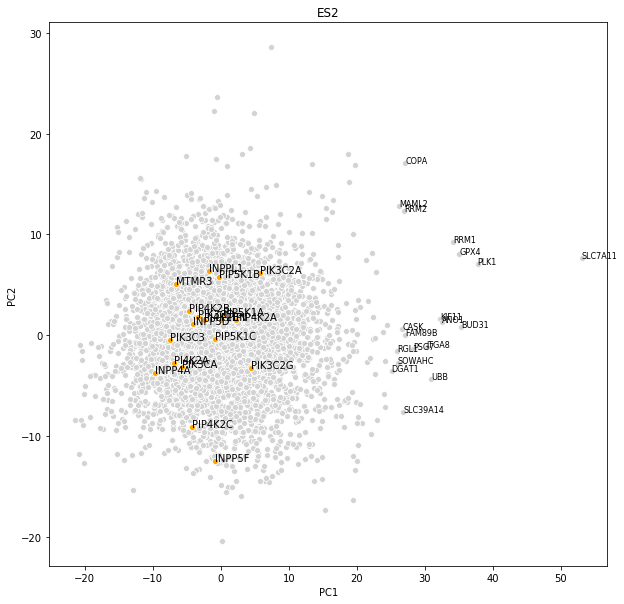

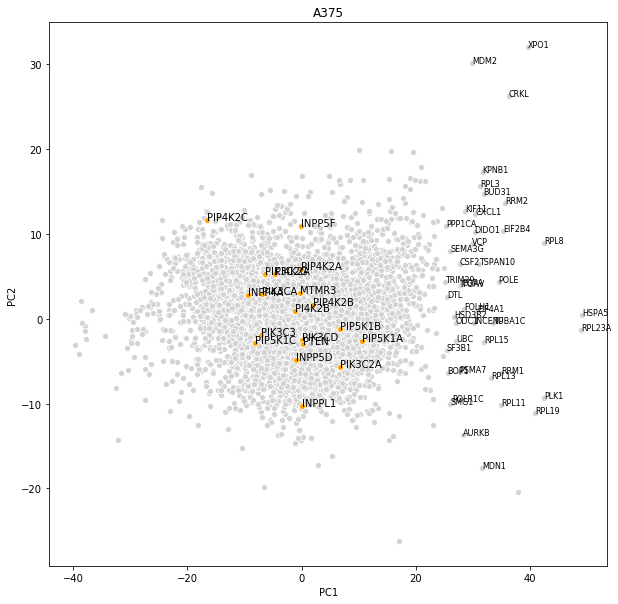

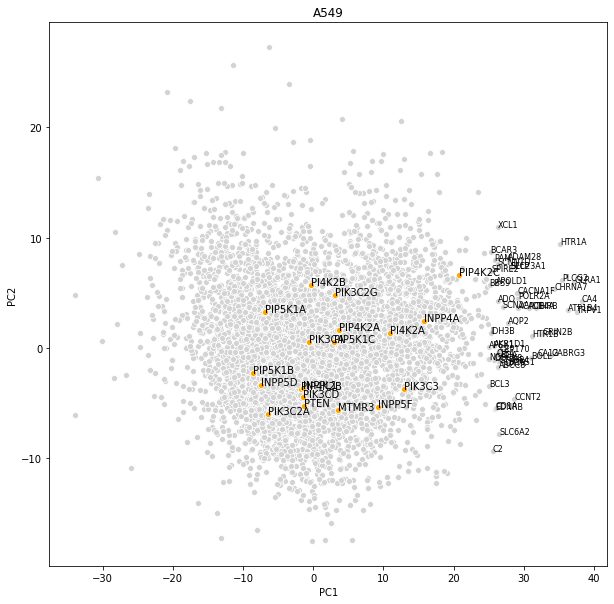

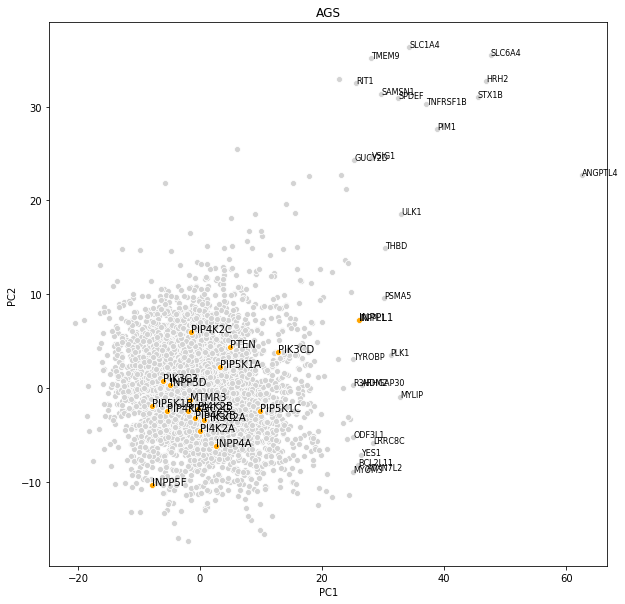

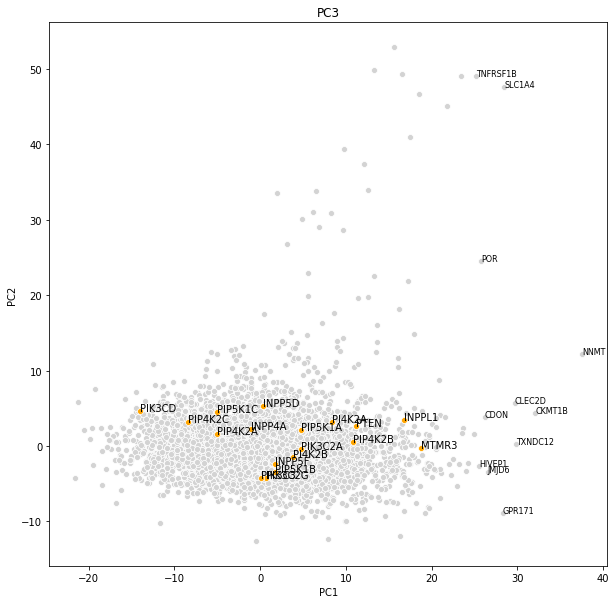

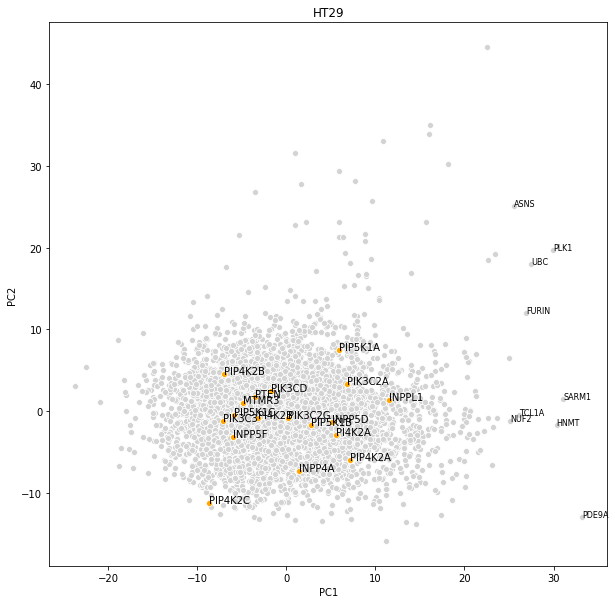

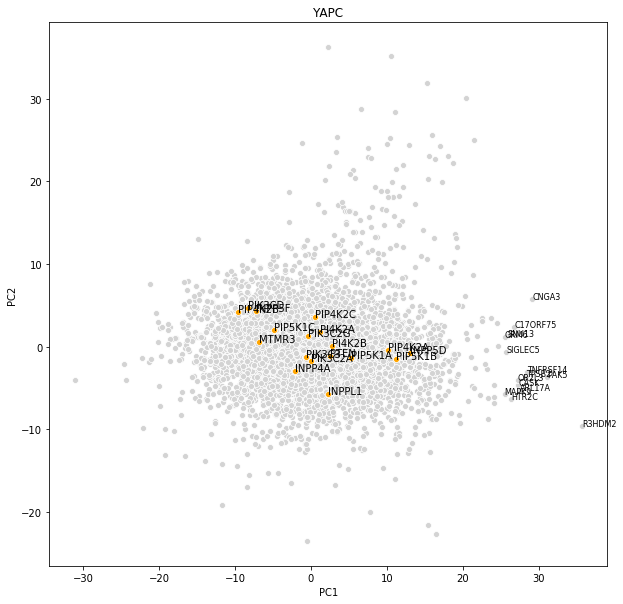

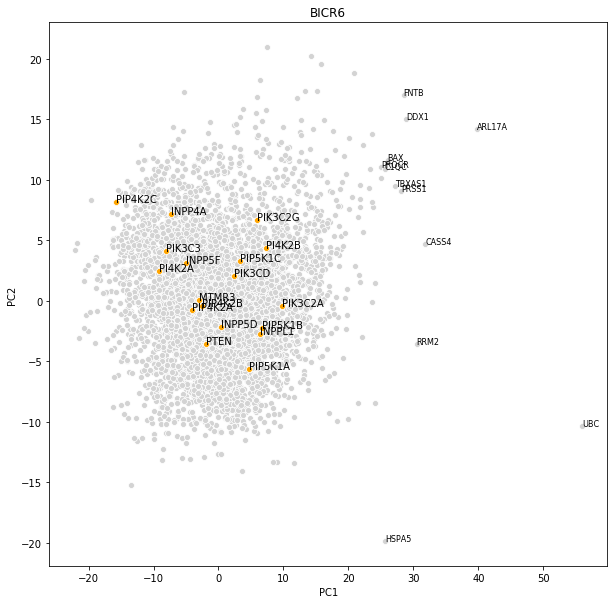

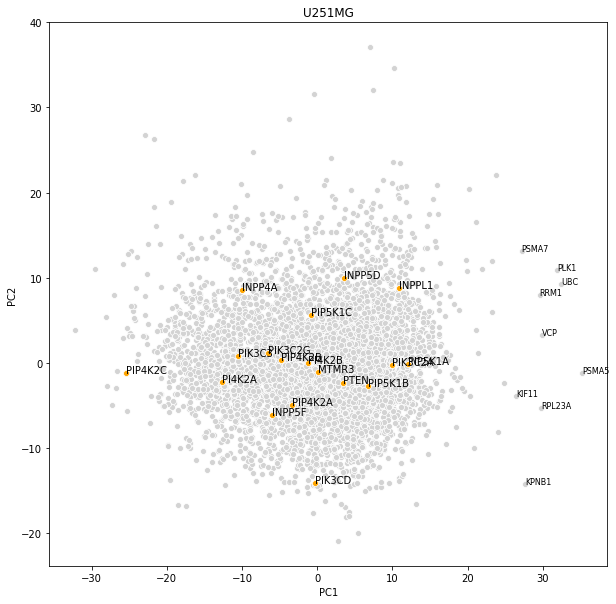

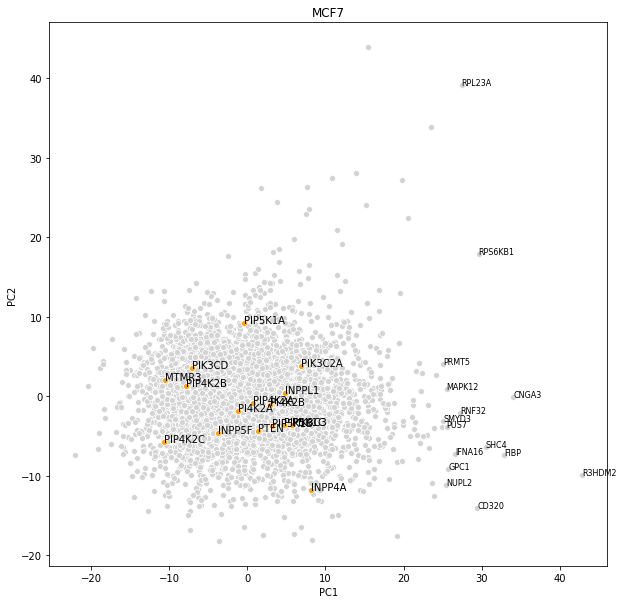

In [591]:
for cell in cells:
    save_pca(cell)

Explained variance ratio:  [0.21931256 0.07250116 0.02163049 0.01782589]


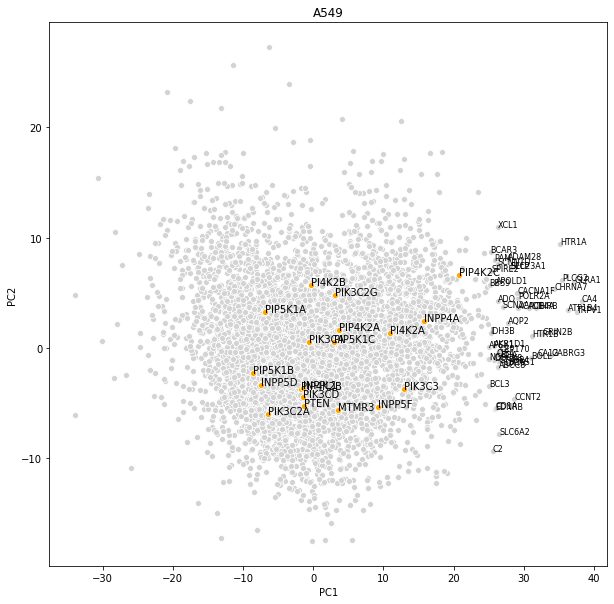

In [232]:
cell = 'A549'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (25, -20), title = cell)

Explained variance ratio:  [0.10355143 0.05492145 0.03413566 0.02327456]


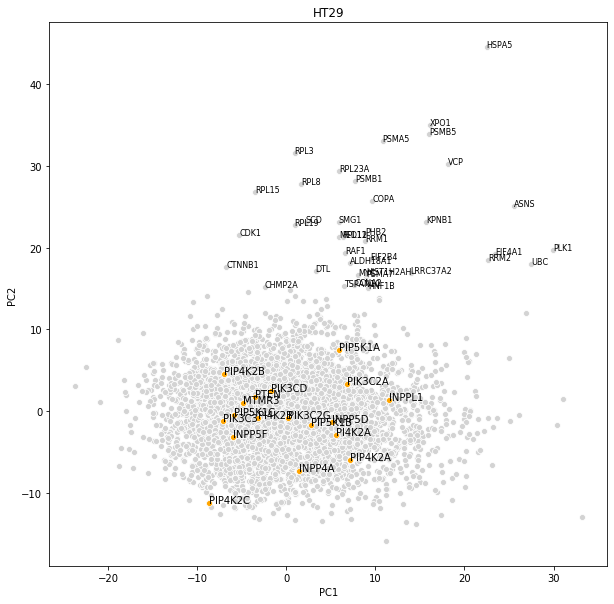

In [234]:
cell = 'HT29'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.12426658 0.06640999 0.0275864  0.0219754 ]


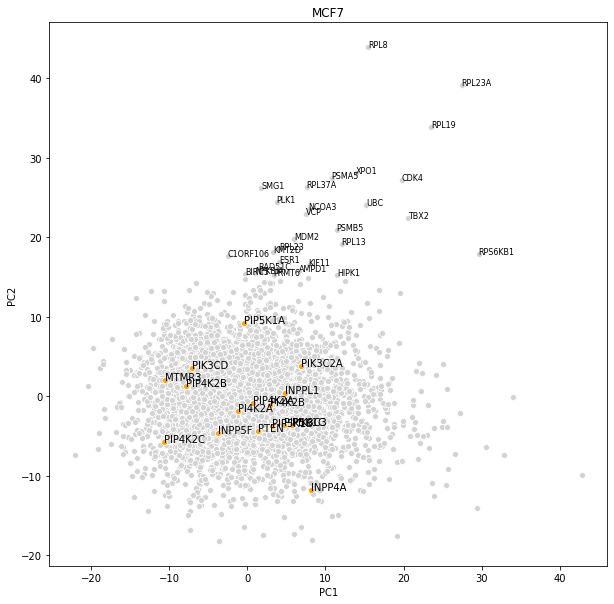

In [235]:
cell = 'MCF7'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.10976148 0.05404685 0.04568008 0.02996135]


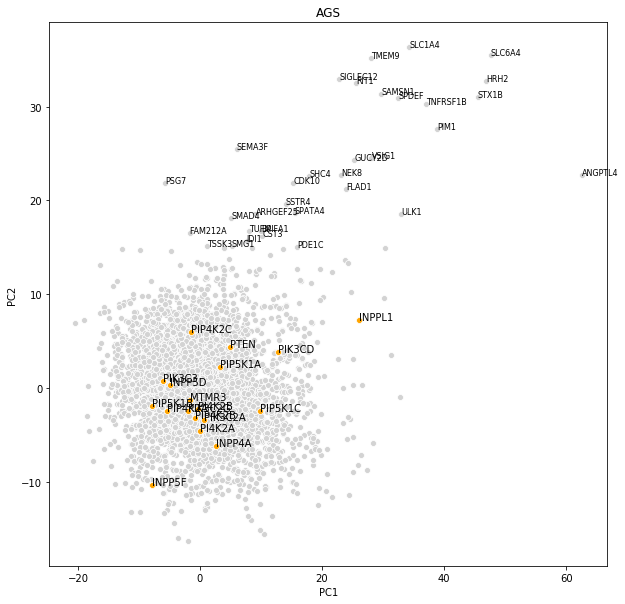

In [237]:
cell = 'AGS'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.11612121 0.05780236 0.0337394  0.0250973 ]


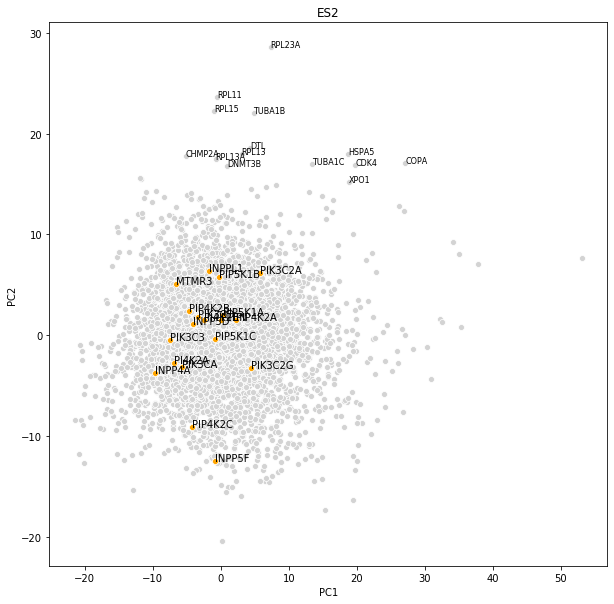

In [247]:
cell = 'ES2'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.11775187 0.04317407 0.03036104 0.02584459]


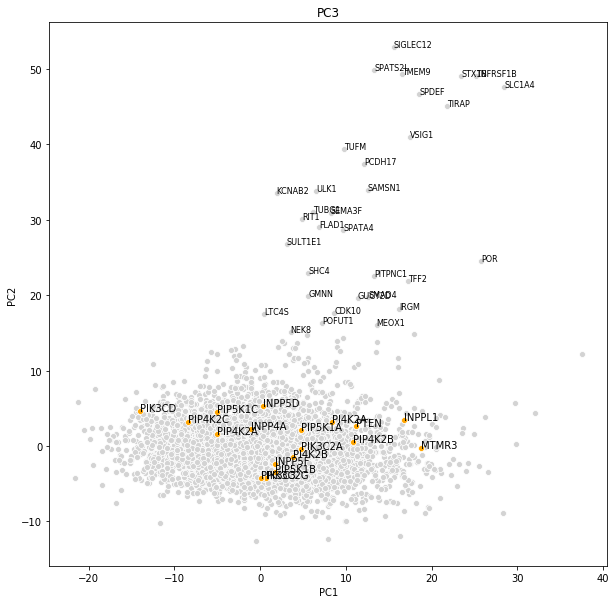

In [244]:
cell = 'PC3'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.13132892 0.05421577 0.03656334 0.0226014 ]


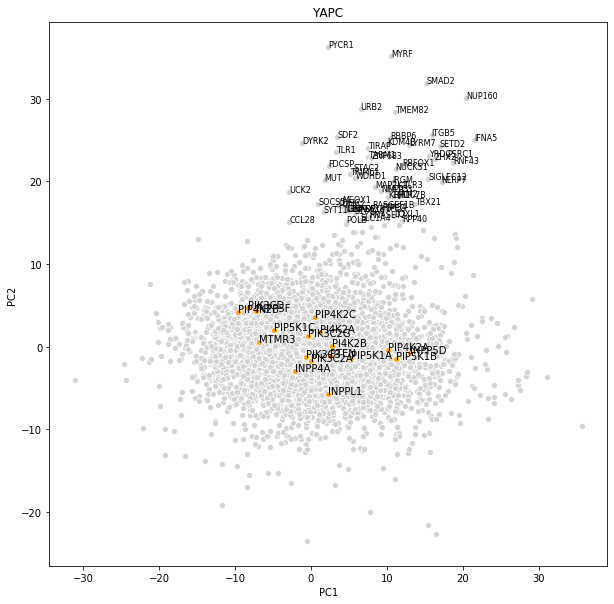

In [239]:
cell = 'YAPC'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.13044007 0.05829478 0.03397484 0.02004777]


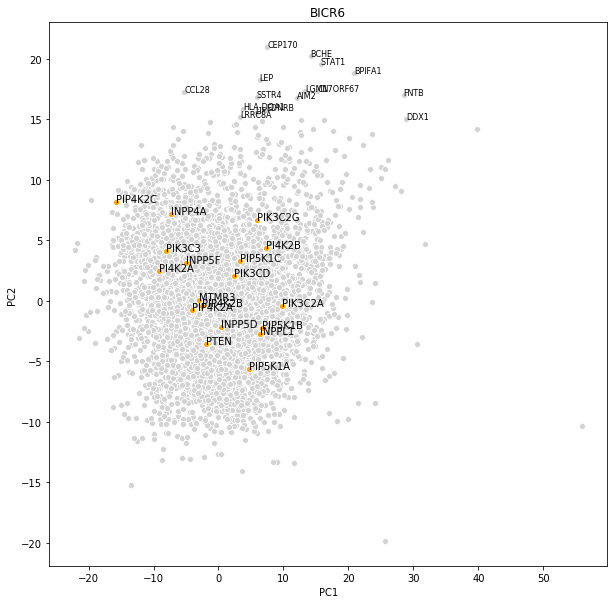

In [240]:
cell = 'BICR6'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-10, 15), title = cell)

Explained variance ratio:  [0.1746407  0.09372591 0.02701859 0.02204846]


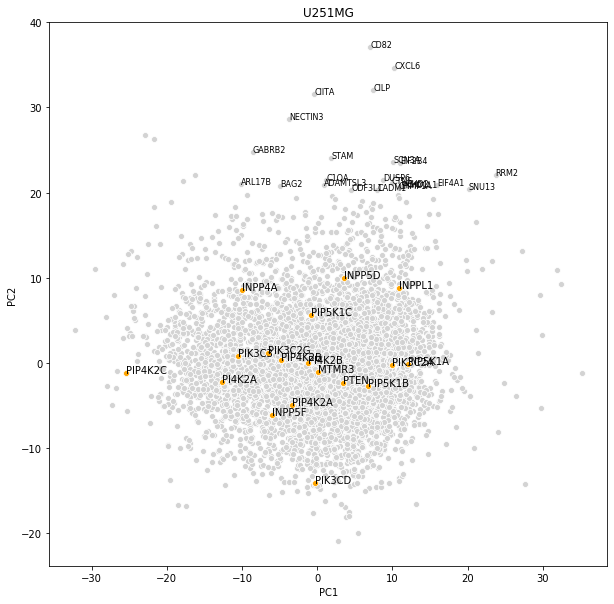

In [242]:
cell = 'U251MG'
pcdf = fit_model_pca(signatures_cells[cell].T)
selected_genes = select_intersecting_genes_from_signatures(kinases+phosphatases, signatures_cells[cell])
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'),
                        above_thd=True, thds = (-15, 20), title = cell)

# Heatmaps

In [262]:
cells = ['ES2', 'A375', 'A549', 'AGS', 'PC3', 'HT29', 'YAPC', 'BICR6', 'U251MG', 'MCF7']


In [263]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [264]:
metadata = pd.read_csv('sasaki_data.csv', index_col = 0)
metadata = metadata.set_index('GeneSymbol', drop=True)

In [265]:
common_genes = kinases+phosphatases
for cell in cells:
    common_genes = set(signatures_cells[cell].columns) & set(common_genes)
    print(cell, len(common_genes), end = ' , ')


ES2 19 , A375 19 , A549 19 , AGS 19 , PC3 19 , HT29 19 , YAPC 19 , BICR6 19 , U251MG 19 , MCF7 19 , 

In [266]:
heatmap_data = {}
for cell in cells:
    heatmap_data[cell] = signatures_cells[cell][common_genes]

In [267]:
# calculate signatures
heatmap_data[cells[0]] = heatmap_data[cells[0]].add_suffix('_'+cells[0])
signatures_all = heatmap_data[cells[0]]

for i in range(1, len(cells)):
    heatmap_data[cells[i]] = heatmap_data[cells[i]].add_suffix('_'+cells[i])
    signatures_all = pd.merge(signatures_all, heatmap_data[cells[i]], left_index = True, right_index = True)

In [302]:
# why NaN values??
signatures_all = signatures_all.dropna(1)

In [303]:
# calculate similarities
common_genes = signatures_all.columns
similarities_all = pd.DataFrame(index = common_genes, columns = common_genes)
for gene in common_genes:
    for pert in common_genes:
        similarities_all.loc[gene, pert] = spearmanr(signatures_all[gene], signatures_all[pert])[0]
similarities_all = similarities_all.astype('float')


In [304]:
def set_column_colors(similarities):
    cl, gs = zip(*similarities.columns.str.split('_', expand = True))
    colors = pd.Series(gs, cl).reset_index()
    colors.columns = ['gene', 'cell']
    
    # add cell color
    colors_dict = dict(zip(colors['cell'].unique(),
                          list(reversed(sns.color_palette("YlGnBu", len(colors['cell'].unique())).as_hex()))))
    colors['cell color'] = colors['cell'].map(colors_dict)
    
    # add gene color
    colors_dict = dict(zip(colors['gene'].unique(),
                          list(reversed(sns.color_palette("coolwarm", len(colors['gene'].unique())).as_hex()))))
    colors['gene color'] = colors['gene'].map(colors_dict)
    
    # add kinase/phosphatase color
    colors['kinase/phosphatase'] =  np.where(colors['gene'].isin(kinases), 'darkblue', 'white')
    
    # add class color
    colors['class'] = colors['gene'].map(metadata['Class'])
    colors_dict = dict(zip(colors['class'].unique(),
                          list(reversed(sns.color_palette("Spectral", len(colors['class'].unique())).as_hex()))))
    colors['class color'] = colors['class'].map(colors_dict)
    
    colors.index = colors['gene'] + '_' + colors['cell']
    
    return colors

In [305]:
def plot_clustermap(similarities, title, figsize = (8,8), save = False, save_as_title = 'untitled'):
    
    colors = set_column_colors(similarities)
    
    colors['clusters'] = clusters.map(dict(zip(clusters.unique(), list(reversed(sns.color_palette("tab10", len(clusters.unique())).as_hex())))))
#     colors['clusters'] = clusters.map({'0':'white', 1:'yellow', 2:'red', 3: 'blue', 4:'k', 5:'orange', 6:'pink'})
    g = sns.clustermap(similarities,  cmap = cmap,  center=0, figsize=figsize, dendrogram_ratio = (0.15, 0.15),
                      col_colors=colors[['clusters', 'cell color', 'gene color', 'kinase/phosphatase', 'class color']],
                       row_colors = colors[['clusters', 'cell color', 'gene color','kinase/phosphatase', 'class color']], vmax = 0.6)
    plt.title(title, fontsize = 14)
    if save == True: plt.savefig(f'{save_as_title}.pdf')

In [307]:
model = AgglomerativeClustering(linkage='average', n_clusters=10)
clusters = pd.Series(model.fit_predict(similarities_all),index=similarities_all.index)

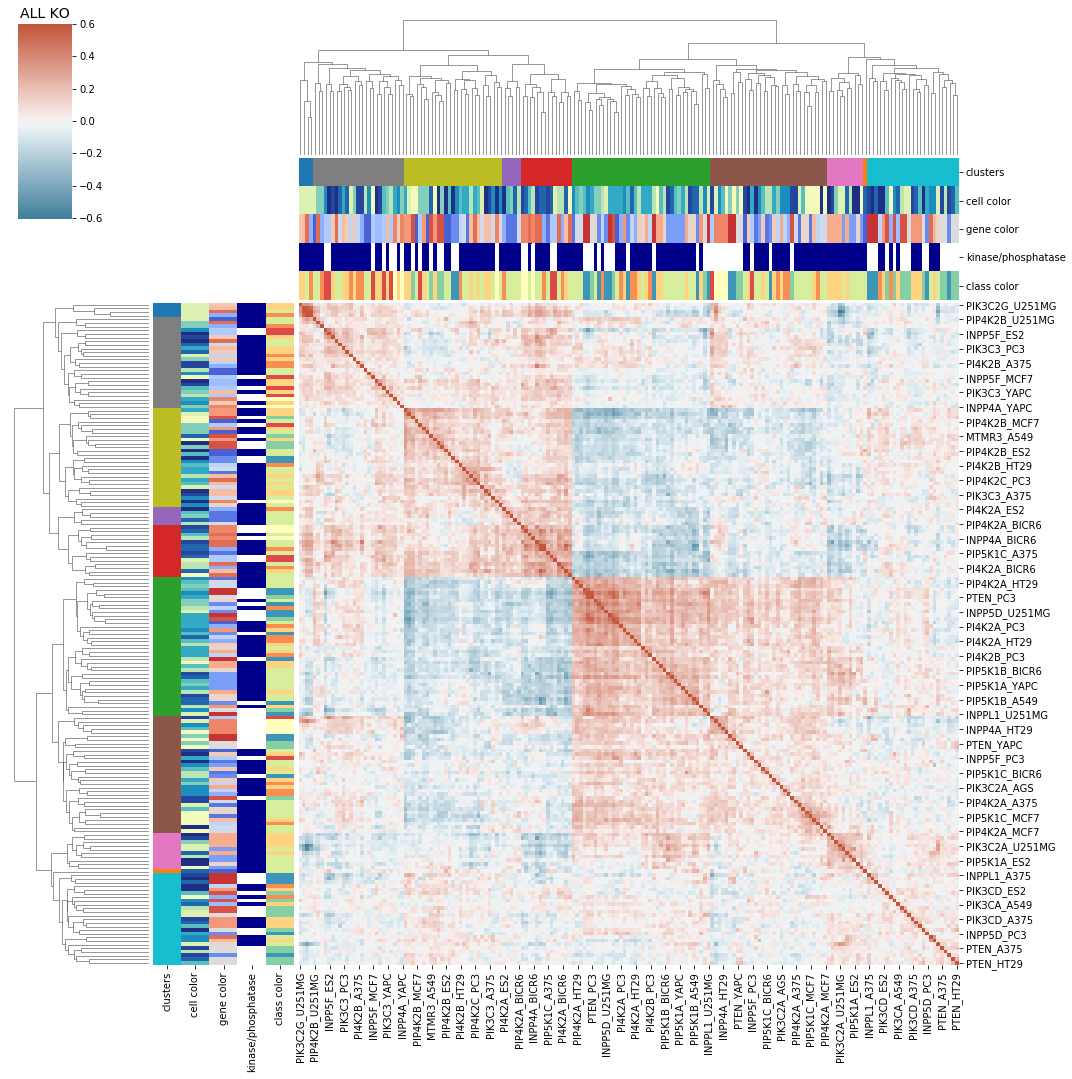

In [308]:
plot_clustermap(similarities_all, title = 'ALL KO', figsize = (15, 15), save = False,
                save_as_title = 'similarities_cells_clustermap')

In [309]:
colors = set_column_colors(similarities_all)

In [310]:
colors[['gene', 'gene color', 'kinase/phosphatase', 'class color']].groupby(['gene', 'gene color', 'kinase/phosphatase', 'class color']).count().reset_index().style.applymap(lambda x: 'background-color: %s' % x)


,gene,gene color,kinase/phosphatase,class color
0,INPP4A,#ee8468,white,#ffffbe
1,INPP5D,#6a8bef,white,#3d95b8
2,INPP5F,#afcafc,white,#dd4a4c
3,INPPL1,#c53334,white,#3d95b8
4,MTMR3,#d65244,white,#86cfa5
5,PI4K2A,#8db0fe,darkblue,#f98e52
6,PI4K2B,#c0d4f5,darkblue,#f98e52
7,PIK3C2A,#f7ac8e,darkblue,#fed481
8,PIK3C2G,#f2cbb7,darkblue,#fed481
9,PIK3C3,#f6bda2,darkblue,#fed481


In [733]:
for i in range(len(clusters.unique())):
    print(i, clusters[clusters == i].count())

0 24
1 22
2 23
3 31
4 11
5 28
6 3
7 1
8 14
9 3


In [311]:
cl_col = clusters.map(dict(zip(clusters.unique(), list(reversed(sns.color_palette("tab10", len(clusters.unique())).as_hex())))))
claster_color = pd.DataFrame([clusters, cl_col], index = ['cluster', 'color']).T
claster_color.groupby(['cluster', 'color']).count().reset_index().style.applymap(lambda x: 'background-color: %s' % x)

,cluster,color
0,0,#7f7f7f
1,1,#17becf
2,2,#8c564b
3,3,#d62728
4,4,#bcbd22
5,5,#e377c2
6,6,#2ca02c
7,7,#ff7f0e
8,8,#1f77b4
9,9,#9467bd


In [65]:
# clusters[clusters == 0]

In [67]:
# colors.loc[clusters[clusters.isin([0,1,6,8,9])].index].groupby(by = 'gene').count()[['cell']].sort_values(by='cell', ascending = False)

In [68]:
# colors.loc[clusters[clusters.isin([0,1,6,8,9])].index].groupby(by = 'cell').count()[['gene']].sort_values(by='gene', ascending = False)

In [69]:
# colors.loc[clusters[clusters == 8].index].sort_values('gene')

In [70]:
# colors.loc[clusters[clusters == 1].index].groupby('cell').count()[['gene']].sort_values(by='gene', ascending = False)

# Cell signatues vs compound signatures

In [315]:
def heatmap_cell_signature_similarities_of_a_perturbation(pert):
    # Similarities of PIK3CD
    perts = [string for string in signatures_all.columns if pert in string]
    #signatures_all[pik3cds]
    # similarities with compounds
    sns.heatmap(similarities_all.loc[perts, perts], cmap = 'coolwarm', center = 0, vmin = -0.5, vmax = 0.5)

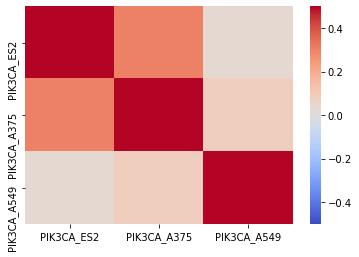

In [317]:
heatmap_cell_signature_similarities_of_a_perturbation('PIK3CA')

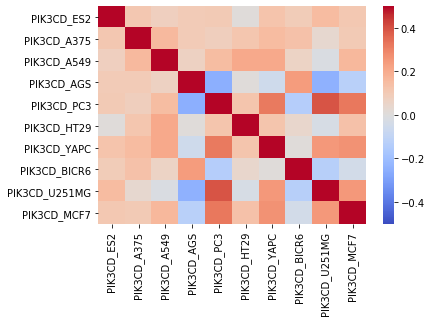

In [318]:
heatmap_cell_signature_similarities_of_a_perturbation('PIK3CD')

In [72]:
signatures_lm_cp = pd.read_csv('signatures_lm_cp.csv', index_col = 0)
sasaki_genes = list(pd.read_csv('sasaki_data.csv', index_col = 0).GeneSymbol)
cp_info=pd.read_table('compoundinfo_beta.txt')
lincs_targets = list(cp_info[['cmap_name', 'target']].dropna().target.unique())
common_genes = set(lincs_targets) & set(sasaki_genes)
targets = cp_info[cp_info.target.isin(list(common_genes))].groupby(['cmap_name', 'target']).count().reset_index()[['cmap_name', 'target']]
common_targets_xpr = ['INPP5D', 'PIK3CD', 'PIK3CA']

In [322]:
def consensus_signatures_density_plot(pert):
    cps_common_target = targets[targets.target == pert].cmap_name
    cp_df_pert =  signatures_lm_cp[set(cps_common_target)&set(signatures_lm_cp.columns)]
    
    perts = [string for string in signatures_all.columns if pert in string]
    perts.sort()
    for pert in perts:
        sns.kdeplot(cp_df_PIK3CD.corrwith(signatures_all[pert].reindex(cp_df_pert.index)), label = pert.split('_')[1])
        plt.legend()

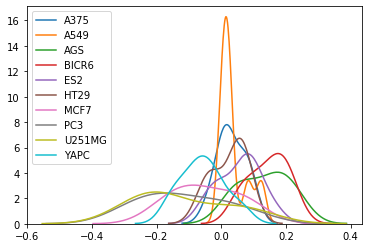

In [323]:
consensus_signatures_density_plot('PIK3CD')

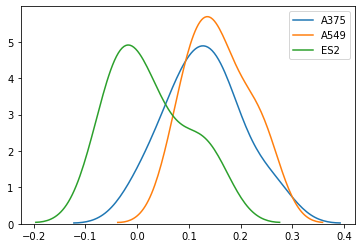

In [324]:
consensus_signatures_density_plot('PIK3CA')

# Calculate cell specific compound signatures of PIK3CD

In [357]:
treatment_type = 'trt_cp'
siginf = select_treatment_type(treatment_type)  
lname = glob(DATA_DIR+'level5_beta_'+treatment_type+'*.gctx')[0]
cp_cells = siginf.cell_iname.unique()

In [358]:
treatment_type = 'trt_xpr'
siginf_xpr = select_treatment_type(treatment_type)  
# xpr_cells = siginf_xpr.cell_iname.unique()
xpr_cells = ['ES2', 'A375', 'A549', 'AGS', 'PC3', 'HT29', 'YAPC', 'BICR6', 'U251MG', 'MCF7']

In [395]:
cells = np.intersect1d(xpr_cells, cp_cells)
cells

array(['A375', 'A549', 'AGS', 'BICR6', 'ES2', 'HT29', 'HUH751', 'K562',
       'MCF7', 'NPC', 'PC3', 'SNGM', 'THP1', 'U251MG', 'U937', 'YAPC'],
      dtype=object)

In [364]:
def get_cpds_with_target(pert):
    cps_common_target = targets[targets.target == pert].cmap_name
    return list(cps_common_target)

In [365]:
def calculate_cp_signature_of_cpds_with_target_and_specific_cells(cells, target):
    
    cmap_names = get_cpds_with_target(target)
    signatures_cell_lm = {}
    for j in range(len(cells)):
        print(j, end = ', ')
        cell = cells[j]
        signatures_lm = pd.DataFrame(index=genes_lm.index, columns=cmap_names)  
        for i in range(len(cmap_names)):
                cname = cmap_names[i]

    #             if i % 100 == 0:
    #                 print(i, end = ',', flush=True)

                sample_ids = siginf[(siginf['cmap_name']==cname) & (siginf['cell_iname']==cell)].index
    #             print(cell, cname, sample_ids)
                if len(sample_ids) == 0:
                    next
                else:
                    gex_lm = parse(lname, cid=sample_ids,rid=genes_lm.index).data_df.loc[genes_lm.index]
                    weights = calc_MODZ(gex_lm)
                    gex_lm = pd.DataFrame(np.dot(gex_lm, weights), index=gex_lm.index, columns=[cname])

                    signatures_lm[cname] = gex_lm[cname]
        signatures_cell_lm[cell] = signatures_lm
    print('done')

    for cell in signatures_cell_lm:
        signatures_cell_lm[cell].index = signatures_cell_lm[cell].index.map(genes_lm)
    return signatures_cell_lm

In [398]:
cells = ['A375', 'A549', 'ES2']
signatures_cell_lm_pik3ca = calculate_cp_signature_of_cpds_with_target_and_specific_cells(cells, 'PIK3CA')

0, 1, 2, done


In [367]:
cells = ['ES2', 'A375', 'A549', 'AGS', 'PC3', 'HT29', 'YAPC', 'BICR6', 'U251MG', 'MCF7']
signatures_cell_lm_pik3cd = calculate_cp_signature_of_cpds_with_target_and_specific_cells(cells, 'PIK3CD')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, done


In [354]:
# signatures_cell_lm = {}
# for j in range(len(cells)):
#     print(j)
#     cell = cells[j]
#     signatures_lm = pd.DataFrame(index=genes_lm.index, columns=cmap_names)  
#     for i in range(len(cmap_names)):
#             cname = cmap_names[i]

# #             if i % 100 == 0:
# #                 print(i, end = ',', flush=True)

#             sample_ids = siginf[(siginf['cmap_name']==cname) & (siginf['cell_iname']==cell)].index
# #             print(cell, cname, sample_ids)
#             if len(sample_ids) == 0:
#                 next
#             else:
#                 gex_lm = parse(lname, cid=sample_ids,rid=genes_lm.index).data_df.loc[genes_lm.index]
#                 weights = calc_MODZ(gex_lm)
#                 gex_lm = pd.DataFrame(np.dot(gex_lm, weights), index=gex_lm.index, columns=[cname])

#                 signatures_lm[cname] = gex_lm[cname]
#     signatures_cell_lm[cell] = signatures_lm
# print('done')

# for cell in signatures_cell_lm:
#     signatures_cell_lm[cell].index = signatures_cell_lm[cell].index.map(genes_lm)

0


TypeError: 'dict_keys' object is not subscriptable

In [385]:
def cell_specific_density_plot(signatures, target):
    cells = list(signatures.keys())
    print(cells)
    for cell in cells:
        sns.kdeplot(signatures[cell].dropna(1).corrwith(signatures_all[target+'_'+cell].reindex(signatures[cell].index)), 
                    label = cell)
        plt.legend()


['A375', 'A549', 'AGS', 'BICR6', 'ES2', 'HT29', 'MCF7', 'PC3', 'U251MG', 'YAPC']


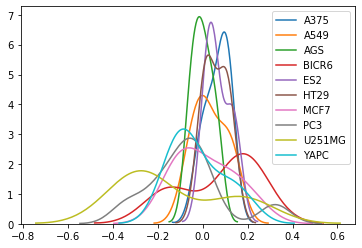

In [386]:
cell_specific_density_plot(signatures_cell_lm_pik3cd, 'PIK3CD')

['A375', 'A549', 'ES2']


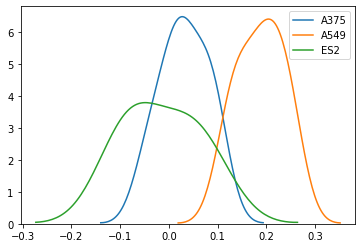

In [399]:
cell_specific_density_plot(signatures_cell_lm_pik3ca, 'PIK3CA')

In [404]:
treatment_type = 'trt_xpr'
siginf = select_treatment_type(treatment_type)  